In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_columns', None)

In [2]:
aisles = pd.read_csv("Data/aisles.csv")
products = pd.read_csv("Data/products.csv")
departments = pd.read_csv("Data/departments.csv")
order_products_prior = pd.read_csv("Data/order_products__prior.csv")
order_products_train = pd.read_csv("Data/order_products__train.csv")
orders = pd.read_csv("Data/orders.csv")

In [3]:
order_products_train = order_products_train.merge(orders.drop('eval_set', axis=1), on='order_id')
order_products_prior = order_products_prior.merge(orders.drop('eval_set', axis=1), on='order_id')

In [4]:
user_product = (order_products_prior.groupby(['product_id','user_id'],as_index=False) 
                                          .agg({'order_id':'count'}) 
                                          .rename(columns={'order_id':'user_product_total_orders'}))

train_ids = order_products_train['user_id'].unique() 
df_X = user_product[user_product['user_id'].isin(train_ids)]
df_X.shape

(8474661, 3)

In [5]:
train_carts = (order_products_train.groupby('user_id',as_index=False)
                                      .agg({'product_id':(lambda x: set(x))})
                                      .rename(columns={'product_id':'latest_cart'}))

df_X = df_X.merge(train_carts, on='user_id')
df_X['in_cart'] = (df_X.apply(lambda row: row['product_id'] in row['latest_cart'], axis=1).astype(int))

df_X.sample(5)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart
5989986,48986,152059,1,"{37067, 17526, 48086, 44090, 16830}",0
4689832,38609,63932,1,"{21376, 10504, 45584, 31378, 33043, 38548, 271...",0
4678375,14194,8316,1,"{32707, 8838, 22952, 4137, 45066, 34283, 41068...",0
5875829,25640,160813,2,"{30561, 45800, 21162, 5450, 9689, 44560, 17872...",0
5958488,1700,57432,3,{16072},0


0    0.9022
1    0.0978
Name: in_cart, dtype: float64


<AxesSubplot: >

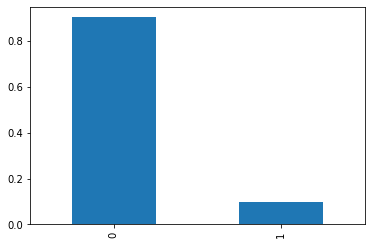

In [6]:
target_pcts = df_X.in_cart.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar')

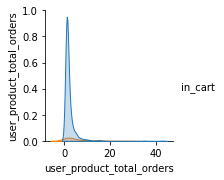

In [7]:
def plot_features(df, sample_size=500):
    
    sample = (df.drop(['product_id','user_id','latest_cart'],axis=1)
                .sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='in_cart', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(df_X)

In [8]:
# Slice data into feature and target

X= df_X.drop(columns=["in_cart","latest_cart","product_id","user_id"])
y= df_X.loc[:,"in_cart"]

In [9]:
#Split data into train, test and validation (%80 - %20)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=5)

In [10]:
classifiers = [
    LogisticRegression()
    ]

In [11]:
log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)
round(log,2)

LogisticRegression
****Results****
Accuracy: 90.2129%
Precision: 4.7069%
Recall: 47.8403%
F1 Score: 8.5706%
ROC AUC: 69.2317%
Log Loss: 0.3002


,Classifier,Accuracy,Precision,Recall,F1Score,ROC AUC,Log Loss
0,LogisticRegression,90.21,4.71,47.84,8.57,69.23,0.3


In [12]:
# Feature Engineering V2,Adding Product Features

prod_features = ['product_total_orders','product_avg_add_to_cart_order']
df_prod_features = (order_products_prior.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('add_to_cart_order','mean')])))

df_prod_features.columns = ['product_id'] + prod_features

df_X = df_X.merge(df_prod_features, on='product_id')

X= df_X.drop(columns=["in_cart","latest_cart","product_id","user_id"])
y= df_X.loc[:,"in_cart"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=5)

classifiers = [
    LogisticRegression(),
    ]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log2 = log.append(log_entry)
    
print("="*30)
round(log2,2)

LogisticRegression
****Results****
Accuracy: 90.1986%
Precision: 5.1976%
Recall: 49.1981%
F1 Score: 9.4019%
ROC AUC: 69.9125%
Log Loss: 0.2978


,Classifier,Accuracy,Precision,Recall,F1Score,ROC AUC,Log Loss
0,LogisticRegression,90.2,5.2,49.2,9.4,69.91,0.3


In [13]:
# Feature Engineering V3,Adding User Features
user_features = ['user_total_orders','user_avg_cartsize','user_total_products','user_avg_days_since_prior_order']

df_user_features = (order_products_prior.groupby(['user_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id',['nunique', (lambda x: x.shape[0] / x.nunique())]),
                                                    ('product_id','nunique'),
                                                    ('days_since_prior_order','mean')])))

df_user_features.columns = ['user_id'] + user_features

df_X = df_X.merge(df_user_features, on='user_id')
df_X = df_X.dropna() # note that this is naive NaN handling for simplicity

X= df_X.drop(columns=["in_cart","latest_cart","product_id","user_id"])
y= df_X.loc[:,"in_cart"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=5)

classifiers = [
    LogisticRegression(),
    ]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log3 = log.append(log_entry)
    
print("="*30)
round(log3,2)

LogisticRegression
****Results****
Accuracy: 90.1620%
Precision: 0.8530%
Recall: 38.2432%
F1 Score: 1.6689%
ROC AUC: 64.2594%
Log Loss: 0.3145


,Classifier,Accuracy,Precision,Recall,F1Score,ROC AUC,Log Loss
0,LogisticRegression,90.16,0.85,38.24,1.67,64.26,0.31


In [14]:
# Feature Engineering V4 Adding User-Product Features

user_prod_features = ['user_product_avg_add_to_cart_order']

df_user_prod_features = (order_products_prior.groupby(['product_id','user_id'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('add_to_cart_order','mean')])))

df_user_prod_features.columns = ['product_id','user_id'] + user_prod_features 

df_X = df_X.merge(df_user_prod_features,on=['user_id','product_id'])
df_X['user_product_order_freq'] = df_X['user_product_total_orders'] / df_X['user_total_orders'] 


#Model V4
X= df_X.drop(columns=["in_cart","latest_cart","product_id","user_id"])
y= df_X.loc[:,"in_cart"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=5)

classifiers = [
    LogisticRegression()]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log4 = log.append(log_entry)
    
print("="*30)

LogisticRegression
****Results****
Accuracy: 90.4101%
Precision: 8.4834%
Recall: 56.7191%
F1 Score: 14.7593%
ROC AUC: 73.8148%
Log Loss: 0.2842


In [15]:
# Feature Engineering V5, Adding Product Category

prod_dep = products.merge(departments, on="department_id")
prod_dep = prod_dep[["product_id","department"]]
df_X = df_X.merge(prod_dep,on="product_id")
df_X = pd.concat([df_X.drop('department',axis=1),pd.get_dummies(df_X["department"])],axis=1)

X= df_X.drop(columns=["in_cart","latest_cart","product_id","user_id"])
y= df_X.loc[:,"in_cart"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=5)

classifiers = [
    LogisticRegression(),
    ]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log5 = log.append(log_entry)
    
print("="*30)
round(log5,2)


LogisticRegression
****Results****
Accuracy: 90.3537%
Precision: 8.2640%
Recall: 55.4591%
F1 Score: 14.3845%
ROC AUC: 73.1651%
Log Loss: 0.2846


,Classifier,Accuracy,Precision,Recall,F1Score,ROC AUC,Log Loss
0,LogisticRegression,90.35,8.26,55.46,14.38,73.17,0.28


In [ ]:
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB()
    ]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log = log.append(log_entry)
print("="*30)
round(log,3)

LogisticRegression
****Results****
Accuracy: 90.3537%
Precision: 8.2640%
Recall: 55.4591%
F1 Score: 14.3845%
ROC AUC: 73.1651%
Log Loss: 0.2846
KNeighborsClassifier
****Results****


In [ ]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()


sns.set_color_codes("muted")
sns.barplot(x='F1Score', y='Classifier', data=log, color="g")

plt.xlabel('F1 Score')
plt.title('Classifier F1 Score')

plt.show()

In [ ]:
sns.set_color_codes("muted")
sns.barplot(x='Precision', y='Classifier', data=log, color="r")

plt.xlabel('Precision %')
plt.title('Classifier Precision')
plt.show()


sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="black")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')

plt.show()

In [ ]:
sns.set_color_codes("muted")
sns.barplot(x='Recall', y='Classifier', data=log, color="#E69F00")

plt.xlabel('Recall %')
plt.title('Classifier Recall')
plt.show()


sns.set_color_codes("muted")
sns.barplot(x='ROC AUC', y='Classifier', data=log, color="#56B4E9")

plt.xlabel('ROC AUC')
plt.title('Classifier ROC AUC')

plt.show()

In [ ]:
classifier = GaussianNB().fit(X_train, y_train)

np.set_printoptions(precision=2)
plt.figure(figsize=(15,10),dpi=200),
plt.style.use('default')

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=["not reorder","reorder"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
classifier = GaussianNB().fit(X_train, y_train)

np.set_printoptions(precision=2)
plt.figure(figsize=(15,10),dpi=200),
plt.style.use('default')

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=["not reorder","reorder"],
                                 cmap=plt.cm.Blues,values_format='.0f'
                                 )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
clf = DecisionTreeClassifier()
#Fit with all the training set
clf.fit(X_train, y_train)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

print("Feature Importance:")
for f in range(X.shape[1]):
    print("%s : (%f)" % (feature_names[f] , importances[indices[f]]))

In [ ]:
X=X[["user_product_total_orders","product_total_orders","product_avg_add_to_cart_order","user_total_orders",
     "user_avg_cartsize","user_total_products","user_avg_days_since_prior_order"]]
y= df_X.loc[:,"in_cart"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=5)

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB()
    ]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log = log.append(log_entry)
print("="*30)
round(log,3)

In [ ]:
target_count = df_X.in_cart.value_counts()
target_count

In [ ]:
# print class balance
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

In [ ]:
target_count.plot(kind='bar', title='Class Count', rot=0);

In [ ]:
#Oversampling
!pip install imblearn

In [ ]:
pip install -U imbalanced-learn 

In [ ]:
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X,y)

In [ ]:
classifiers = [
    RandomForestClassifier()
    ]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_resampled, y_resampled)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)
round(log,3)

In [ ]:
ros = RandomOverSampler(random_state=0)
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X,y)
classifiers = [
    
    KNeighborsClassifier()
    ]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_smoted, y_smoted)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)
round(log,3)

In [ ]:
scores1 = cross_val_score(RandomForestClassifier(), X_smoted, y_smoted, cv=10, scoring="accuracy")
scores2 = cross_val_score(RandomForestClassifier(), X_smoted, y_smoted, cv=10, scoring="recall")
scores3 = cross_val_score(RandomForestClassifier(), X_smoted, y_smoted, cv=10, scoring="precision")
scores4 = cross_val_score(RandomForestClassifier(), X_smoted, y_smoted, cv=10, scoring="f1_macro")

print("Mean Accuracy: ", scores1.mean())
print("Mean Precision: ", scores3.mean())
print("Mean Recall: ", scores2.mean())
print("Mean F1 Score: ", scores4.mean())

In [ ]:
# using the default threshold of 0.5, which is what vanilla predict does
y_predict = clf.predict(X_smoted)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_smoted, y_predict), 
                                                     recall_score(y_smoted, y_predict)))

In [ ]:
# using the new threshold of 0.06
y_predict = (clf.predict_proba(X_test)[:,1] > 0.07)
print("Threshold of 0.06:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

In [ ]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score


precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_smoted, clf.predict_proba(X_smoted)[:,1] )

plt.figure(figsize=(10,7),dpi=100),
plt.style.use('default')
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability');
plt.title('Precision and Recall Curves');

In [ ]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

In [ ]:
classifier = KNeighborsClassifier().fit(X_smoted, y_smoted)

np.set_printoptions(precision=2)
plt.figure(figsize=(15,10),dpi=200),
plt.style.use('default')

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=["not reorder","reorder"],
                                 cmap=plt.cm.Blues,values_format='.0f'
                                 )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
classifier = KNeighborsClassifier().fit(X_train, y_train)

np.set_printoptions(precision=2)
plt.figure(figsize=(15,10),dpi=200),
plt.style.use('default')

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=["not reorder","reorder"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()